In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import scipy

In [52]:
def load_joint_data(npz_path):
    """
    Loads joint data from an .npz file.

    Args:
        npz_path (str): Path to the .npz file.

    Returns:
        timestamps (np.array): Array of timestamps.
        raw_data (np.array): Array of raw joint data (shoulder, elbow, wrist).
    """
    data = np.load(npz_path)
    timestamps = data['timestamps']
    raw_data = data['raw_data']
    return timestamps, raw_data


def calculate_elbow_angle(joint_data):
    """
    Calculates the elbow angle for each frame based on shoulder, elbow, and wrist coordinates.

    Args:
        joint_data (np.array): Array of joint coordinates with shape (n_frames, 6).
                               Each row contains [shoulder_x, shoulder_y, elbow_x, elbow_y, wrist_x, wrist_y].

    Returns:
        angles (np.array): Array of elbow angles in degrees for each frame.
    """
    angles = []
    for frame in joint_data:
        shoulder = frame[:2]
        elbow = frame[2:4]
        wrist = frame[4:6]

        # Calculate vectors
        ba = shoulder - elbow
        bc = wrist - elbow

        # Calculate the angle using the dot product
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        angles.append(np.degrees(angle))

    return np.array(angles)


def detect_reps(angles, timestamps, sigma=10, min_distance=5, min_peak_prominence=5):
    """
    Detects repetitions by identifying peaks (arms extended) in the elbow angle signal.
    Each rep spans from one peak to the next, ensuring contiguous segments covering the entire recording.

    Args:
        angles (np.array): Array of elbow angles over time.
        timestamps (np.array): Array of corresponding timestamps.
        sigma (float): Smoothing factor for the angles.
        min_distance (int): Minimum distance between peaks (in samples).
        min_peak_prominence (float): Minimum prominence required for a peak.

    Returns:
        rep_segments (list): List of tuples (start_time, end_time) for each rep.
        angles_smoothed (np.array): The smoothed angle data.
    """
    # Smooth the angles using Gaussian filter
    angles_smoothed = scipy.ndimage.gaussian_filter1d(angles, sigma=sigma)
    
    # Find peaks (maxima) - these correspond to the elbow being fully extended
    peaks, _ = scipy.signal.find_peaks(
        angles_smoothed, 
        distance=min_distance,
        prominence=min_peak_prominence
    )
    
    # Ensure we have at least one peak to identify repetitions
    if len(peaks) < 1:
        return [], angles_smoothed
    
    # Create rep segments between consecutive peaks and include the beginning and end
    rep_segments = []
    
    # Add first segment from beginning to first peak (if not at the very beginning)
    if peaks[0] > 0:
        rep_segments.append((timestamps[0], timestamps[peaks[0]]))
    
    # Add segments between consecutive peaks
    for i in range(len(peaks) - 1):
        start_idx = peaks[i]
        end_idx = peaks[i + 1]
        start_time = timestamps[start_idx]
        end_time = timestamps[end_idx]
        rep_segments.append((start_time, end_time))
    
    # Add last segment from last peak to end (if not at the very end)
    if peaks[-1] < len(timestamps) - 1:
        rep_segments.append((timestamps[peaks[-1]], timestamps[-1]))
    
    return rep_segments, angles_smoothed



def process_all_npz_files(data_dir, show_graph=False):
    """
    Processes all .npz files in a directory, performs rep segmentation, and plots the results.

    Args:
        data_dir (str): Path to the directory containing .npz files.
        show_graph (bool): Whether to display the graph of rep segmentation.

    Returns:
        dict: Dictionary mapping filenames to rep segments.
    """
    rep_data = {}
    npz_files = [f for f in os.listdir(data_dir) if f.endswith('.npz')]
    
    # Create a single figure with subplots for all files
    num_files = len(npz_files)
    fig, axes = plt.subplots(num_files, 1, figsize=(15, 2*num_files), squeeze=False)
    
    for idx, npz_file in enumerate(npz_files):
        npz_path = os.path.join(data_dir, npz_file)
        print(f"Processing {npz_file}...")

        # Load joint data
        timestamps, raw_data = load_joint_data(npz_path)

        # Calculate elbow angles
        angles = calculate_elbow_angle(raw_data)
        print(f"Shape of angles: {angles.shape}")

        # Smooth the angles
        angles_smoothed = scipy.ndimage.gaussian_filter1d(angles, sigma=10)
        print(f"Shape of angles_smoothed: {angles_smoothed.shape}")

        # Detect repetitions
        rep_segments, _ = detect_reps(angles, timestamps)

        # Store rep segments
        rep_data[npz_file] = rep_segments

        # Plot in the corresponding subplot if show_graph is True
        if show_graph:
            ax = axes[idx, 0]
            
            ax.plot(timestamps, angles, 'b-', label='Raw Elbow Angle', alpha=0.3)
            ax.plot(timestamps, angles_smoothed, 'r-', label='Smoothed Elbow Angle', alpha=0.7)
            
            # Highlight the periods considered as repetitions with alternating colors
            colors = ['green', 'magenta']
            for i, (start, end) in enumerate(rep_segments):
                color = colors[i % len(colors)]  # Cycle through colors
                ax.axvspan(start, end, color=color, alpha=0.3, label=f'Rep {i + 1}' if i == 0 else None)
            
            # Add labels and title
            ax.set_xlabel('Time (seconds)')
            ax.set_ylabel('Angle (°)')
            ax.set_title(f'{npz_file}', fontsize=8)
            ax.invert_yaxis()
            ax.grid(True)
            
            # Add legend only to the first subplot to save space
            if idx == 0:
                ax.legend(loc='upper right', fontsize='small')
    
    if show_graph:
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.4)
        plt.show()
    return rep_data


Processing IMG_5760_cut.npz...
Shape of angles: (1630,)
Shape of angles_smoothed: (1630,)
Processing IMG_5770_cut.npz...
Shape of angles: (928,)
Shape of angles_smoothed: (928,)
Processing IMG_5805_cut.npz...
Shape of angles: (992,)
Shape of angles_smoothed: (992,)
Processing IMG_5794_cut.npz...
Shape of angles: (486,)
Shape of angles_smoothed: (486,)
Processing IMG_5779_cut.npz...
Shape of angles: (1270,)
Shape of angles_smoothed: (1270,)
Processing IMG_5769_cut.npz...
Shape of angles: (1970,)
Shape of angles_smoothed: (1970,)
Processing IMG_5746_cut.npz...
Shape of angles: (1562,)
Shape of angles_smoothed: (1562,)
Processing IMG_5756_cut.npz...
Shape of angles: (2993,)
Shape of angles_smoothed: (2993,)
Processing IMG_5768_cut.npz...
Shape of angles: (1765,)
Shape of angles_smoothed: (1765,)
Processing IMG_5778_cut.npz...
Shape of angles: (1372,)
Shape of angles_smoothed: (1372,)
Processing IMG_5757_cut.npz...
Shape of angles: (2477,)
Shape of angles_smoothed: (2477,)
Processing IMG_5

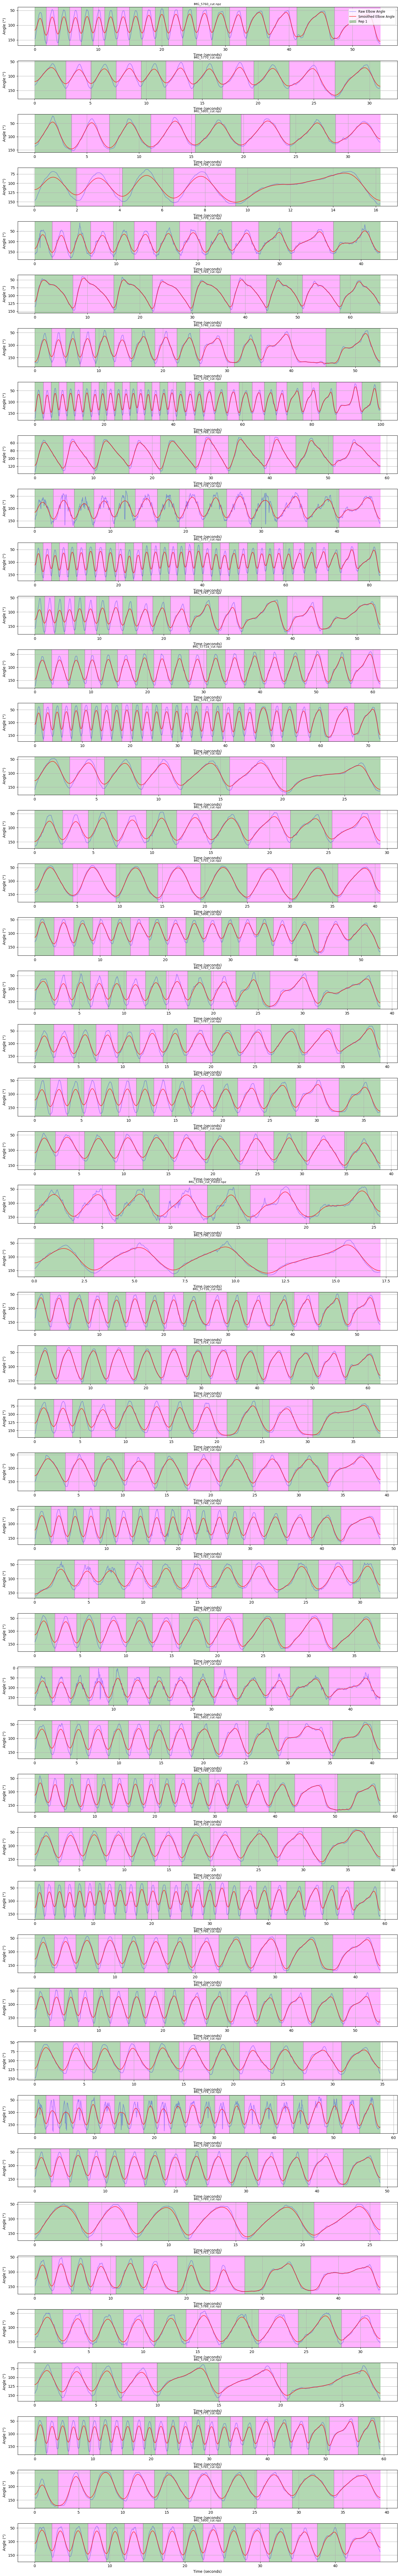

In [53]:

data_dir = "./raw_joint_data_npz"

# Process all .npz files and perform rep segmentation
rep_data = process_all_npz_files(data_dir, show_graph=True)

In [58]:
def save_video_reps(video_name, reps_data, save_dir='processed_data'):
    """
    Save rep data for a single video to a .npz file.

    Args:
        video_name (str): Name of the video file
        reps_data (list): List of numpy arrays containing rep data for each repetition.
                          Each array should have shape (timesteps, n_features).
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Define the save path for the .npz file
    save_path = os.path.join(save_dir, video_name.replace('.mp4', '.npz'))
    
    # Create a dictionary where each repetition is stored with a key like 'rep_0', 'rep_1', etc.
    save_dict = {f'rep_{i}': rep for i, rep in enumerate(reps_data)}
    
    # Save the dictionary to a compressed .npz file
    np.savez_compressed(save_path, **save_dict)
    
    print(f"Saved {len(reps_data)} reps for {video_name} to {save_path}")



def prepare_and_save_model_data(rep_data, data_dir, output_dir='data_to_model_npz'):
    """
    Prepare and save model data from the rep segmentation data.
    Each set (original file) will be saved as one NPZ file containing all its reps.
    
    Args:
        rep_data (dict): Dictionary mapping filenames to lists of (start_time, end_time) tuples
        data_dir (str): Directory containing the original NPZ files
        output_dir (str): Directory to save the model data
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for filename, rep_segments in rep_data.items():
        # Load the original data for this file
        npz_path = os.path.join(data_dir, filename)
        timestamps, raw_data = load_joint_data(npz_path)
        
        # Calculate elbow angles for the entire sequence
        all_angles = calculate_elbow_angle(raw_data)
        
        # Prepare a list to store data for all reps
        reps_data = []
        
        # Process each rep
        for start_time, end_time in rep_segments:
            # Find indices corresponding to the start and end times
            start_idx = np.argmin(np.abs(timestamps - start_time))
            end_idx = np.argmin(np.abs(timestamps - end_time))
            
            # Extract data for this rep
            rep_joint_data = raw_data[start_idx:end_idx+1]
            
            # Append to the list of reps
            reps_data.append(rep_joint_data)
        
        # Save all reps for this set to a single NPZ file
        save_video_reps(filename, reps_data, output_dir)
        print(f"Saved model data for {filename} with {len(rep_segments)} reps")
    
    print(f"All model data saved to {output_dir}")


In [60]:
prepare_and_save_model_data(rep_data, data_dir)

Saved 20 reps for IMG_5760_cut.npz to data_to_model_npz/IMG_5760_cut.npz
Saved model data for IMG_5760_cut.npz with 20 reps
Saved 11 reps for IMG_5770_cut.npz to data_to_model_npz/IMG_5770_cut.npz
Saved model data for IMG_5770_cut.npz with 11 reps
Saved 8 reps for IMG_5805_cut.npz to data_to_model_npz/IMG_5805_cut.npz
Saved model data for IMG_5805_cut.npz with 8 reps
Saved 5 reps for IMG_5794_cut.npz to data_to_model_npz/IMG_5794_cut.npz
Saved model data for IMG_5794_cut.npz with 5 reps
Saved 13 reps for IMG_5779_cut.npz to data_to_model_npz/IMG_5779_cut.npz
Saved model data for IMG_5779_cut.npz with 13 reps
Saved 9 reps for IMG_5769_cut.npz to data_to_model_npz/IMG_5769_cut.npz
Saved model data for IMG_5769_cut.npz with 9 reps
Saved 13 reps for IMG_5746_cut.npz to data_to_model_npz/IMG_5746_cut.npz
Saved model data for IMG_5746_cut.npz with 13 reps
Saved 33 reps for IMG_5756_cut.npz to data_to_model_npz/IMG_5756_cut.npz
Saved model data for IMG_5756_cut.npz with 33 reps
Saved 10 reps 